# Cats and Dogs Classification with pretrained CNN - Fine Tuning


This notebook is an extention of tutorial 2B, we will use a pretrained model for Cats vs Dogs classification in **PyTorch** and introduce **Albumentations** - a Python library for image augmentation.


Same as before, we will use the **Cat and Dog** dataset from Kaggle, which contains 10,028 RGB images: 8,005 for training (4,000 cats + 4,005 dogs) and 2,023 for testing (1,011 cats + 1,012 dogs), along with 4 _DS_Store files that will be automatically ignored by ImageFolder during loading. The images have different sizes, so some preprocessing will be necessary.

First, the needed imports. If you are using Colab, it provides a pre-configured PyTorch environment, so we just need to import the relevant packages.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.5.1+cu124
Using GPU, device name: Tesla T4


# Load and Augment the Dataset

We can download and load the **Cat and Dog** dataset from kagglehub. This will be downloaded to the .cache folder. If you are using Colab, it corresponds to the /root/.cache folder, which is a temporary storage space, so you will need to re-download it every time you reconnect. If you are using a local environment, it corresponds to the /username/.cache folder, which only requires a one-time download but will take approximately 237MB memory space.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

100%|██████████| 218M/218M [00:02<00:00, 110MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1


In [ ]:
# If download succcesfully, this should output 1012
files = os.listdir(path+"/test_set/test_set/cats")
print(f"Files number: {len(files)}")

Files number: 1012


Now we are ready to load the data, but before that, we need to preprocess the images, including data augmentation. The preprocessing here is mainly about image resizing to ensure consistent image size and convert to Tensor. In the previous tutorial, we used `torchvision.transforms` to achieve this. Now, we introduce a new augmentation library called `Albumentations`.


**Albumentations** is a powerful Python library for image augmentation. Image augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. It's normally used in deep learning and computer vision tasks to increase the quality of trained models.

Here is an example of how you can apply some pixel-level augmentations from Albumentations to create new images from the original one:


![alt text](https://camo.githubusercontent.com/f0c1aae777f4926fbd07c604333053b05dedbb90991a1520162e68a7c1e6275f/68747470733a2f2f686162726173746f726167652e6f72672f776562742f62642f6e652f72762f62646e6572763563746b75646d73617a6e687734637273646669772e6a706567)

First, we need to install this library if you haven't already. If you are using Colab, the library is pre-configured, but usually with an old version. You can still use the following command to upgrade it to the latest version.

In [ ]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 34.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


The good news is that the usage of `albumentations` is almost the same to `torchvision.transforms`, so you can easily get familiar with it. **It's important that**, since `ImageFolder` loads images in PIL format, but `Albumentations` only accepts NumPy arrays as input, we need to convert the `PIL.Image` to a `NumPy array` before passing it to the transform. Then, we extract the ["image"] part from the output and transform it to tensor. This is why we use a `lambda` function inside `ImageFolder` to handle this conversion.


Compared to torchvision.transforms, **[Albumentations](https://github.com/albumentations-team/albumentations)** offers more powerful augmentation operations, such as Cutout and GridDistortion. It also supports more computer vision tasks like image segmentation and small object detection.


As an example, we only use horizontal flipping and rotation here. You are free to explore more augmentation operations.

In [ ]:
import albumentations as A

image_size = 128

# Data augmentation and preprocessing
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),  # random horizontal flip
    A.Rotate(limit=30, p=0.5),  # random rotation up to 15 degree
    A.Resize(height=image_size, width=image_size),  # Image Resize
])

transform_test = A.Compose([
    A.Resize(height=image_size, width=image_size),  # Image Resize
])

# torchvision.transforms.ToTensor() as the final step
to_tensor = transforms.ToTensor()

# Load dataset from local folders
train_dataset = datasets.ImageFolder(root=path+"/training_set/training_set", transform=lambda img: to_tensor(transform_train(image=np.array(img))["image"]))
test_val_dataset = datasets.ImageFolder(root=path+"/test_set/test_set", transform=lambda img: to_tensor(transform_test(image=np.array(img))["image"]))

# split validation set (25%) and test set (75%) from the original test_set
total_size = len(test_val_dataset)
val_size = total_size // 4
test_size = total_size - val_size

test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])


# Define data loaders to feed the data to the model during training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# check the data information
print(f"Classes: {train_dataset.classes}")  # output: ['cats', 'dogs']
print(f"Classes index: {train_dataset.class_to_idx}") # output: {'cats': 0, 'dogs': 1}
print("Number of training samples:", len(train_dataset))
print("Number of val samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))


Classes: ['cats', 'dogs']
Classes index: {'cats': 0, 'dogs': 1}
Number of training samples: 8005
Number of val samples: 505
Number of test samples: 1518


The data loaders provide a way of iterating (making a loop over) the datasets, each time getting a new batch of data with the given batch size.

The first element of the data batch (`data`) is a 4th-order tensor of size (`batch_size`, 3, `image_size`, `image_size`), i.e. assuming `image_size` is 128, it consists of a batch of images of size 3x128x128 pixels, where the first value is the number of color channels.

The second element of the batch (`target`) is a vector containing the correct (or "target") classes ("0" or "1") for cats or dogs.

In [ ]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 3, 128, 128]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


# Visualize Some Sample Images
Let's visualize the first six images from the training set:

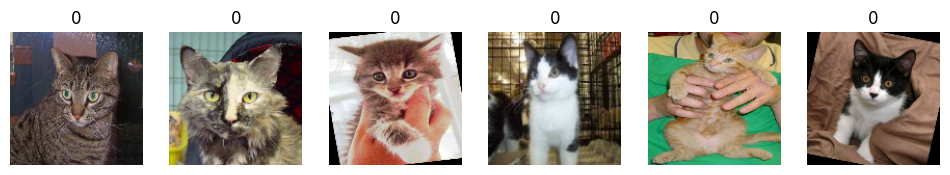

In [ ]:
fig = plt.figure(figsize=(12, 2))
for i in range(6):
    image, label = train_dataset[i]
    ax = fig.add_subplot(1, 6, i+1)
    ax.imshow(image.permute(1, 2, 0)) # convert dimentions to adapt Matplotlib
    ax.set_title(str(label))
    ax.axis('off')
plt.show()


# Fine tuning

## Define the model in PyTorch

The task of fine-tuning a network is to *tweak* the parameters of an already trained network so that it adapts to the new task. The initial layers learn very general features, whereas, as we delve into the network, the layers tend to learn patterns that are more specific to that specific task. Thus, to fine-tune a pre-trained network, we want to *freeze* the initial layers (i.e., they cannot be trained anymore) and re-train the deepest (or final) layers on the new task.

**Our case**: We load the weights of VGG16 pre-trained on Imagenet, we freeze every layer but the last four (fully connected layers), which will be re-trained from that initial state.

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)





We can directly load the pretrained VGG16 model from `torchvision.models`. After printing its structure, you will notice that the model consists of three main parts:


* `features`: This contains the convolutional layers, responsible for extracting key features.
* `avgpool`: This is the pooling layer, used for further downsampling.
* `classifier`: This is the fully connected layers, which performs the final classification task.


Therefore, we only need to freeze the parameters in the `features` section, which means it will not be updated during training. Then, execute the whole training process again on our own dataset, we can obtain a new `classifier` adapted to our new dataset. This process is known as **Transfer Learning**.

In [ ]:
import torch
import torchvision.models as models

# Load pretrained VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model = model.to(device)

# Print model structure
print(model)

# Freeze convolution layers, so that we only train on classifier part
for param in model.features.parameters():
    param.requires_grad = False


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Define the Loss Function and Optimizer

Same as the previous lab, we need to define a loss function and an optimizer.

For a classification task we typically use the cross entropy loss. For this we can use the class [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

Also, we need to define an optimizer, which tells how to update the model parameters based on the computed gradients. There are [several different optimizer algorithms implemented in PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms).

You might notice that here we only pass the parameters of the `classifier` to the optimizer. Since we have already frozen the previous layers, passing the entire model's parameters wouldn't affect the frozen layers. However, we recommend this approach as it reduces computational cost and improves training efficiency.

In [ ]:
criterion = nn.CrossEntropyLoss()  # combines softmax + cross entropy
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Training the Model

After the previous lab, you should be familiar with defining the training process.

Here, we train the model for 20 epochs. During each epoch, we:

1. Set the model to training mode (model.train()).
2.  Loop over the train_loader, compute the loss, do backpropagation, and update parameters.
3. Evaluate on the test set (used here as the validation set, as in your original example).
4. Track the best validation accuracy and save the model weights (model.weights.best.hdf5) whenever we see an improvement.

First, a helper function to calculate the number of correctly classified samples.

In [ ]:
def correct(output, target):
    predicted_digits = output.argmax(1)                # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                  # count number of correct ones


In [ ]:
epochs = 20
best_acc = 0.0
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Compute the loss
        loss = criterion(outputs, labels)

        # 4. Backpropagation
        loss.backward()

        # 5. Update parameters
        optimizer.step()

        # Accumulate the training loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_acc += correct(outputs, labels)

    # Compute average training loss and accuracy over an epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * running_acc / len(train_loader.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Evaluate on the test set
    model.eval()
    val_correct = 0
    val_loss_count = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_count += loss.item() * images.size(0)
            val_correct += correct(outputs,labels)

    val_loss_epoch = val_loss_count / len(val_loader.dataset)
    val_acc_epoch = 100.0 * val_correct / len(val_loader.dataset)

    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {val_acc_epoch:.2f}%")

    # Save the model if the test accuracy is the best we've seen so far
    if val_acc_epoch > best_acc:
        best_acc = val_acc_epoch
        torch.save(model.state_dict(), 'model.weights.best.hdf5')
        print("  --> Model saved.")


Epoch [1/20], Loss: 0.7564, Accuracy: 87.25%, Test Accuracy: 95.05%
  --> Model saved.
Epoch [2/20], Loss: 0.4574, Accuracy: 89.14%, Test Accuracy: 85.74%
Epoch [3/20], Loss: 0.3998, Accuracy: 90.18%, Test Accuracy: 95.05%
Epoch [4/20], Loss: 0.3433, Accuracy: 90.22%, Test Accuracy: 91.88%
Epoch [5/20], Loss: 0.3696, Accuracy: 90.77%, Test Accuracy: 91.88%
Epoch [6/20], Loss: 0.3004, Accuracy: 91.39%, Test Accuracy: 95.25%
  --> Model saved.
Epoch [7/20], Loss: 0.2881, Accuracy: 91.71%, Test Accuracy: 95.25%
Epoch [8/20], Loss: 0.2973, Accuracy: 91.98%, Test Accuracy: 94.26%
Epoch [9/20], Loss: 0.2631, Accuracy: 92.53%, Test Accuracy: 95.45%
  --> Model saved.
Epoch [10/20], Loss: 0.2583, Accuracy: 92.48%, Test Accuracy: 95.84%
  --> Model saved.
Epoch [11/20], Loss: 0.2316, Accuracy: 92.95%, Test Accuracy: 94.65%
Epoch [12/20], Loss: 0.2294, Accuracy: 92.48%, Test Accuracy: 94.46%
Epoch [13/20], Loss: 0.2812, Accuracy: 92.27%, Test Accuracy: 95.25%
Epoch [14/20], Loss: 0.2718, Accurac

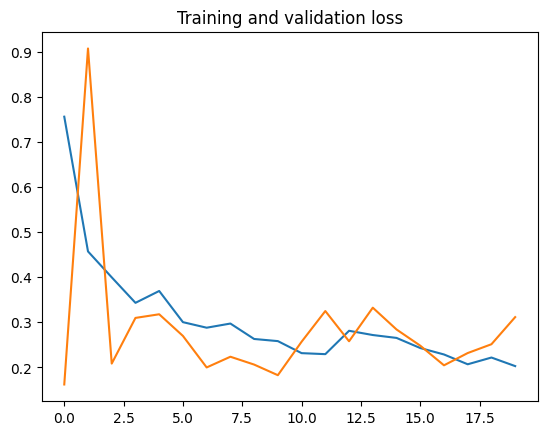

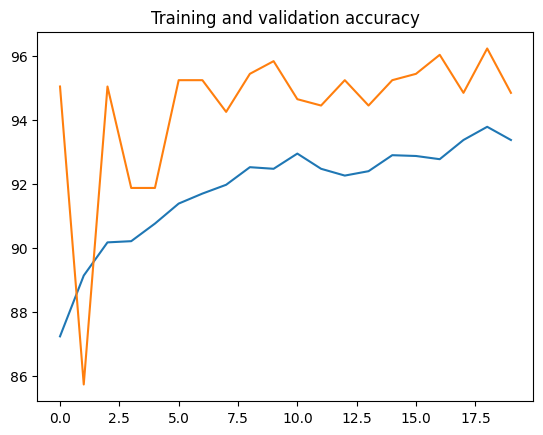

In [ ]:
# plot learning curve
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), train_loss, label="train_loss")
plt.plot(np.arange(0, epochs), val_loss, label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), train_acc, label="train_acc")
plt.plot(np.arange(0, epochs), val_acc, label="val_acc")

# Load the Best Model and Evaluate on the Test Set
Finally, we load the saved weights that gave the highest accuracy on the test set and report our test accuracy again:

In [ ]:
# Load the best saved model
model.load_state_dict(torch.load('model.weights.best.hdf5', weights_only=False))
model.eval()

test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += correct(outputs,labels)

test_accuracy = 100.0 * test_correct / len(test_loader.dataset)
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")


Best Model Test Accuracy: 94.27%


## Task: Compare and DIY

Compare the performance of fine tuning with the results obtained from Tutorial 2B (simple CNN). What do you observe?

Now, you task is to explore and familiarize yourself with the use of fine tuning. You can try with more pretrained CNN architectures (ResNet, EfficientNet) and modify it with different approaches.